 __Importar las librerias que voy a utilizar para analizar el Dataset__

In [23]:
# Librerias para analisis, algebra, visualización y transformación de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_summary import DataFrameSummary
from os import path

# Librerias para texto
import regex as re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
import contractions

__Librerias necesarias a instalar:__

In [2]:
# pip install contractions
# pip install pyLDAvis
# pip install fasttext
# pip install gensim

__Cargar el DataSet__

In [3]:
df = pd.read_csv('../data/raw/file_name.csv')

In [4]:
df.head(5)

,Title,Political Lean,Score,Id,Subreddit,URL,Num of Comments,Text,Date Created
0,"No matter who someone is, how they look like, ...",Liberal,1,t5fybt,socialism,https://v.redd.it/ng5fyl7hp2l81,0,NaN,1.646272e+09
1,Biden speech draws 38.2 million U.S. TV viewers,Liberal,6,t5fqdn,democrats,https://www.reuters.com/world/us/biden-speech-...,1,NaN,1.646271e+09
2,State of the union,Liberal,1,t5fj9a,DemocraticSocialism,https://www.reddit.com/r/DemocraticSocialism/c...,1,Who watched the state of the union last night ...,1.646270e+09
3,We Should Just Give Poor People Money,Liberal,7,t5f7n9,SocialDemocracy,https://youtu.be/a80kRjpubG0,3,NaN,1.646270e+09
4,Do it for the Dew,Liberal,6,t5es2c,democrats,https://i.redd.it/drmunn90f2l81.jpg,1,NaN,1.646268e+09


In [5]:
data_summary = DataFrameSummary(df)
data_summary.columns_stats.T

,counts,uniques,missing,missing_perc,types
Title,12854,12324,0,0%,categorical
Political Lean,12854,2,0,0%,bool
Score,12854,974,0,0%,numeric
Id,12854,12854,0,0%,unique
Subreddit,12854,15,0,0%,categorical
URL,12854,12327,0,0%,categorical
Num of Comments,12854,312,0,0%,numeric
Text,2428,2390,10426,81.11%,categorical
Date Created,12854,12833,0,0%,numeric


La columna Text tiene un 81% de valores Null

In [7]:
# Paso las columnas a minusculas por comodidad
df.columns= df.columns.str.lower()

__Elimino las columnas inutiles como ID y Date Created__

In [8]:
df.drop(['id', 'date created'], axis =1, inplace = True)

__Variable a predecir Political Lean__

In [10]:
df['political lean'].unique()

array(['Liberal', 'Conservative'], dtype=object)

In [14]:
# Variables para los colores en las gráficas
colors = {'Liberal':'red',
        'Conservative':'blue'}
color = ('#E16666','#6682E1')
labels = ['Liberal','Conservative']

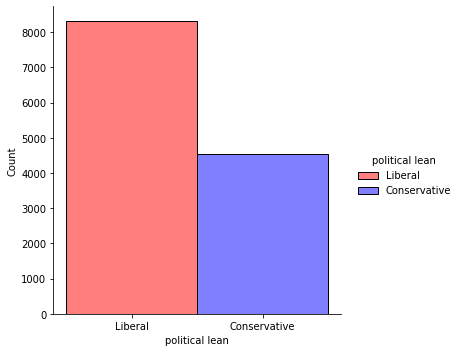

In [13]:
sns.displot(data=df, x="political lean", 
            palette=colors, hue="political lean", kde=True);

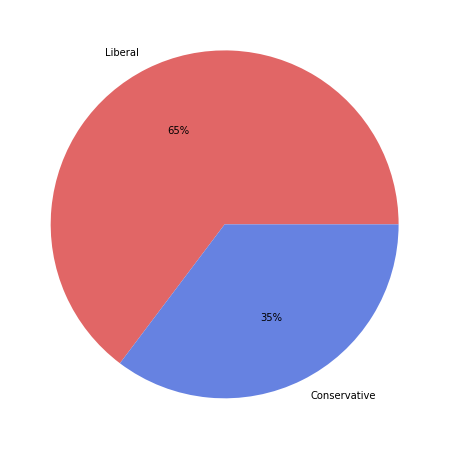

In [15]:
plt.figure(figsize=(8,8))
plt.pie(df['political lean'].value_counts(),labels=labels, colors=color ,autopct = '%0.0f%%')
plt.show()

Tenemos un problema de clasificación y la target esta desbalanceada.

Exploración del resto de columnas:

#### Subreddit

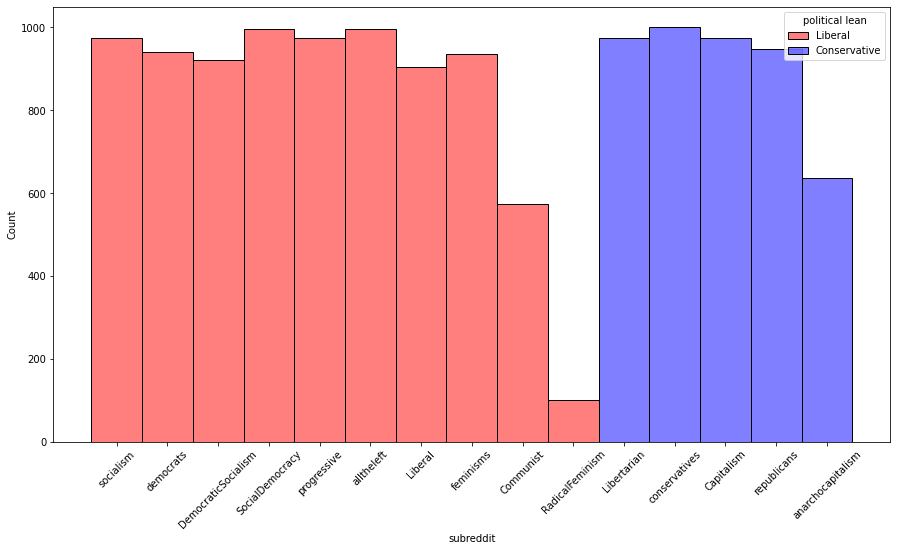

In [16]:
plt.figure(figsize = (15,8))
ax = sns.histplot(data=df,x='subreddit', hue='political lean',palette=colors)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45);

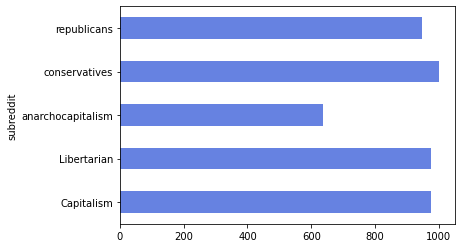

In [17]:
df_temp = df.loc[df['political lean'] == 'Conservative'].reset_index(drop=True)
df_temp.groupby('subreddit')['political lean'].count().plot(kind= 'barh', color='#6682E1');

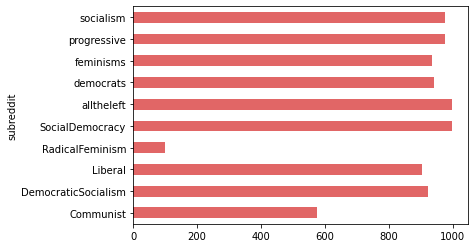

In [18]:
df_temp = df.loc[df['political lean'] == 'Liberal'].reset_index(drop=True)
df_temp.groupby('subreddit')['political lean'].count().plot(kind= 'barh', color='#E16666');

#### Score

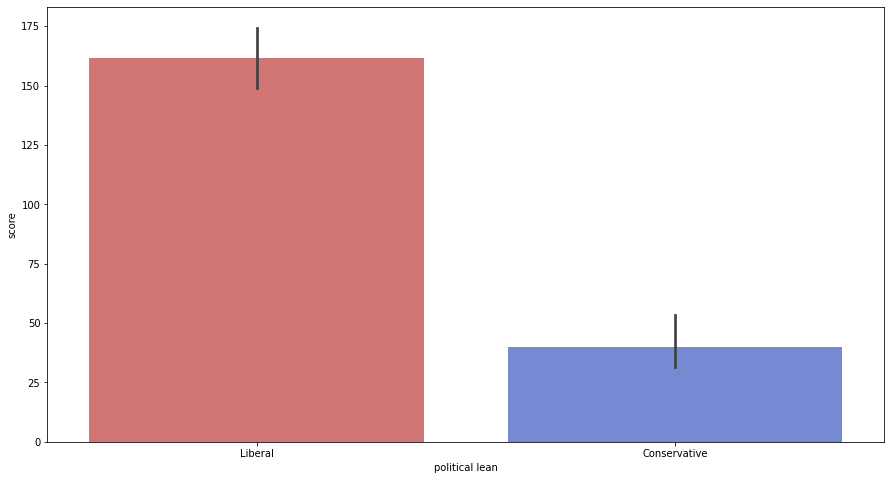

In [19]:
plt.figure(figsize = (15,8))
sns.barplot(y=df['score'],x=df['political lean'], palette=color);

Textos

In [24]:
'''
    Función para procesar textos en ingles,
    ingresas el texto y sale limpio
'''

def process_text(text):
    
    #tokenize the text
    text = word_tokenize(text)
    
    #Expand contractions 
    text = [contractions.fix(word) for word in text]
    
    #only alphabets
    text = [ re.sub('[^A-Za-z]+', '', word) for word in text]
    
    #lowercase
    text = [word.lower() for word in text if word.isalpha()]
    
    #stopwords
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word not in stop_words]
    
    #Lemmatizer
    text = [WordNetLemmatizer().lemmatize(word) for word in text]
    
    text = ' '.join(text)
    return text

__URL__

Esta columna es distinta a las demás de texto, voy a quedarme solo con las webs

In [25]:
df['url'] = df['url'].apply(lambda x: x.replace('https://',''))
df['url'] = df['url'].apply(lambda x: x.replace('http://',''))
df['url'] = df['url'].apply(lambda x: x.replace('/','.'))

In [26]:
df['url'] = df['url'].str.split('.')

In [27]:
webs = []

def urls():
    for i in df['url']:
        webs.append(i[0:2])
urls()

In [28]:
webs_2 = []

def add():
    for i in webs:
        webs_2.append('.'.join(i))
add()

In [29]:
df['webs'] = webs_2

In [35]:
df['webs'] = df['webs'].str.replace('www.','')
df['webs'] = df['webs'].str.replace('.org','')
df['webs'] = df['webs'].str.replace('.com','')
df['webs'] = df['webs'].str.replace('.net','')
df['webs'] = df['webs'].str.replace('i.redd','reddit')
df['webs'] = df['webs'].str.replace('.','')

c:\Users\Carmelo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
c:\Users\Carmelo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
c:\Users\Carmelo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\Carmelo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
c:\Users\Carmelo\AppData\Local\Programs\Python\Python

In [36]:
df['webs'].value_counts()

reddit            4075
youtube            889
washingtonpost     275
nytimes            266
cnn                210
                  ... 
theirisnyc           1
pairagraph           1
prescottenews        1
newsthump            1
wikimises            1
Name: webs, Length: 1719, dtype: int64

In [37]:
df['webs'] = df['webs'].apply(process_text)

In [38]:
lista = []
for word in df['webs']:
    lista.append(word)

In [40]:
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

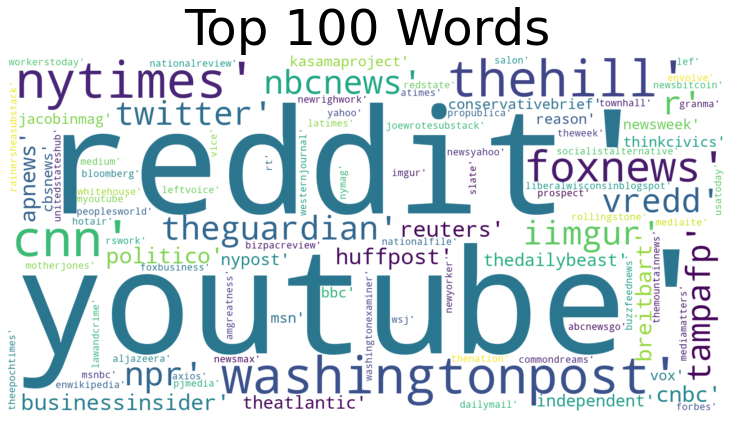

In [41]:
def top100plot(lista):    
    mostcommon = FreqDist(lista).most_common(100)
    wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
    plt.figure(figsize=(10,10), facecolor='white')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title('Top 100 Words', fontsize=50)
    plt.tight_layout(pad=0)
    return plt.show()

top100plot(lista)

In [42]:
df.drop(columns='url',inplace=True)

Columna Text, tiene mucho values NaN, es decir que no me será util. Pero quiero visualizar los datos para entender mejor el DataFrame

In [43]:
df['text'].fillna('', inplace=True)

In [44]:
df['text'] = df['text'].apply(process_text)

In [45]:
lista = []

for word in df['text']:
    lista.append(word)

In [57]:
from sklearn.feature_extraction.text import CountVectorizer

In [56]:
def get_top_ngram(corpus, n): # Entrada, cuerpo del texto, y numero de palabras frecuentes
    
    '''
    Función para conseguir el 
    numero de palabras mas frecuentes
    '''

    lis=[]
    vec = CountVectorizer(ngram_range = (n,n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    for word,idx in vec.vocabulary_.items():
        lis.append((word, sum_words[0,idx]))
    lis.sort(key = lambda x: x[1], reverse = True)
    return lis    

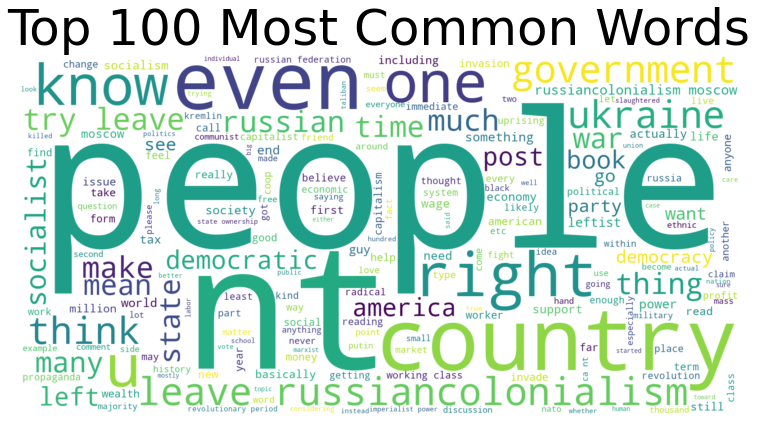

In [46]:
mostcommon = FreqDist(lista).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(10,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

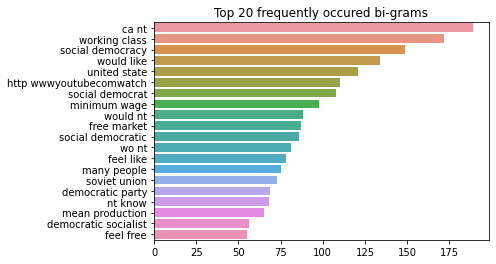

In [54]:
# Top dos clave
top_n_bigrams=get_top_ngram(df['text'],2)[:20]
x,y=map(list,zip(*top_n_bigrams)) 
plt.title('Top 20 frequently occured bi-grams')
sns.barplot(x=y,y=x);

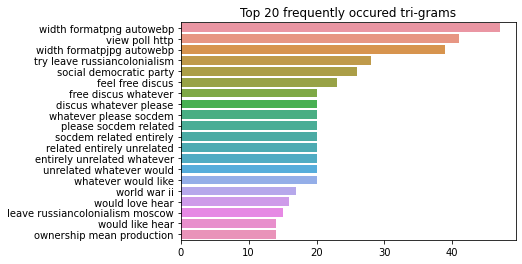

In [55]:
# Top tres palabras
top_n_bigrams=get_top_ngram(df['text'],3)[:20]
x,y=map(list,zip(*top_n_bigrams)) 
plt.title('Top 20 frequently occured tri-grams')
sns.barplot(x=y,y=x);

__Columna Title__

In [47]:
df['title'] = df['title'].apply(process_text)

In [48]:
lista = []

for word in df['title']:
    lista.append(word)

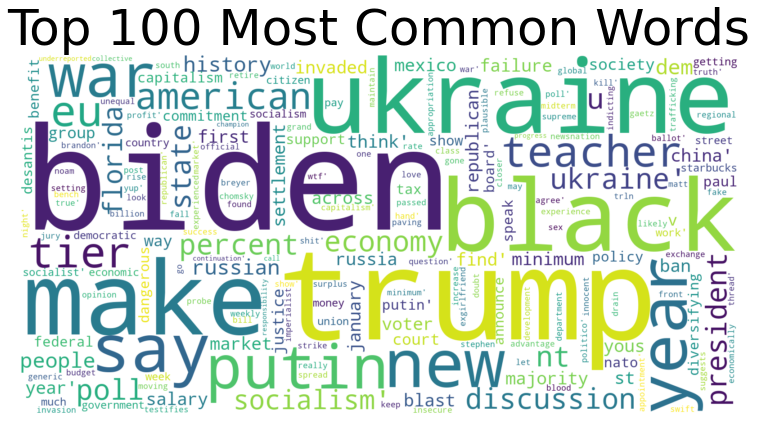

In [49]:
mostcommon = FreqDist(lista).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(10,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

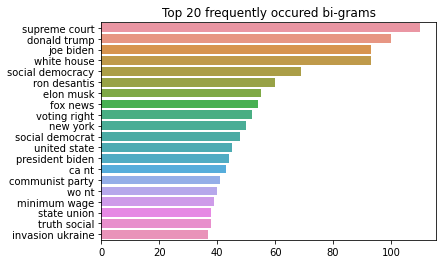

In [52]:
# Top dos clave
top_n_bigrams=get_top_ngram(df['title'],2)[:20]
x,y=map(list,zip(*top_n_bigrams)) 
plt.title('Top 20 frequently occured bi-grams')
sns.barplot(x=y,y=x);

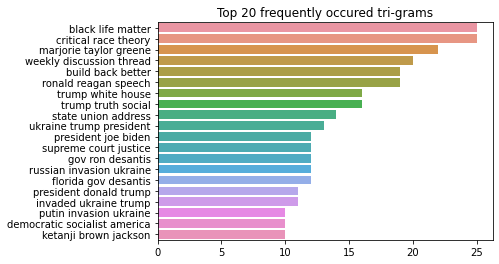

In [53]:
# Top tres palabras
top_n_bigrams=get_top_ngram(df['title'],3)[:20]
x,y=map(list,zip(*top_n_bigrams)) 
plt.title('Top 20 frequently occured tri-grams')
sns.barplot(x=y,y=x);